In [1]:
import pandas as pd


# df = pd.read_csv(r'combined_csvs\final_output.csv')
df = pd.read_csv(r'data\CD11b_sk38_tissue 11_Detailed.csv', skiprows=3)
df

,Position X,Position Y,Position Z,Unit,Category,Collection,Time,Set 1,ID,Unnamed: 9
0,51619.285,42545.438,12.502,µm,Surface,Position,1,Class A,0,NaN
1,51618.191,42549.020,16.524,µm,Surface,Position,1,Class A,1,NaN
2,51434.113,42733.695,17.081,µm,Surface,Position,1,Class A,2,NaN
3,51478.602,42688.203,17.455,µm,Surface,Position,1,Class A,3,NaN
4,51325.926,42841.258,25.160,µm,Surface,Position,1,Class A,5,NaN
...,...,...,...,...,...,...,...,...,...,...
29129,48763.258,40756.102,25.430,µm,Surface,Position,1,Class B,29120,NaN
29130,49183.871,40337.605,26.580,µm,Surface,Position,1,Class B,29124,NaN
29131,48653.125,40877.785,16.615,µm,Surface,Position,1,Class B,29125,NaN
29132,48661.957,40872.906,16.566,µm,Surface,Position,1,Class B,29126,NaN


In [3]:
# df = df[df['CD11B'] == 1 ]
# df =  df[(df['CD11B'] == 1) & (df['MDSC'] == 1)].copy()

# df_both_stains = df
df = df.rename(columns={'Position X': 'POSITION X', 'Position Y': 'POSITION Y'})

df.columns

Index(['POSITION X', 'POSITION Y', 'Position Z', 'Unit', 'Category',
       'Collection', 'Time', 'Set 1', 'ID', 'Unnamed: 9'],
      dtype='object')

In [4]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load and scale data
coords = df[['POSITION X', 'POSITION Y']].values
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Determine optimal number of GMM components using BIC
bic_scores = []
n_components_range = range(1,25)  # Try from 1 to 15 clusters
models = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(coords_scaled)
    bic_scores.append(gmm.bic(coords_scaled))
    models.append(gmm)

# Choose best model based on lowest BIC
best_index = np.argmin(bic_scores)
best_gmm = models[best_index]
print(f"Optimal number of clusters: {n_components_range[best_index]}")

# Predict labels and probabilities
labels = best_gmm.predict(coords_scaled)
probs = best_gmm.predict_proba(coords_scaled)
max_probs = probs.max(axis=1)

# Filter points by probability threshold
mask = max_probs >= 0.01
filtered_coords = coords[mask]
filtered_labels = labels[mask]


Optimal number of clusters: 20


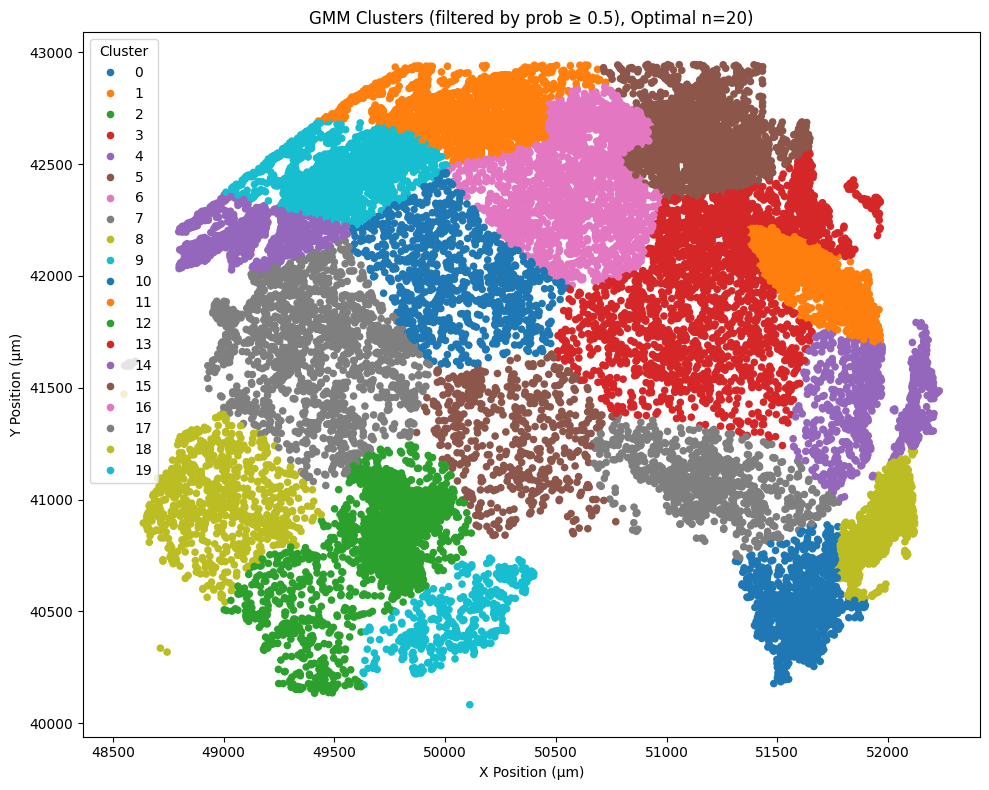

In [5]:

# Create DataFrame for plotting
df_filtered = pd.DataFrame(filtered_coords, columns=['POSITION X', 'POSITION Y'])
df_filtered['cluster'] = filtered_labels

# Plot the filtered clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_filtered,
    x='POSITION X', y='POSITION Y',
    hue='cluster', palette='tab10', s=30, linewidth=0
)
plt.title(f'GMM Clusters (filtered by prob ≥ 0.5), Optimal n={n_components_range[best_index]})')
plt.xlabel('X Position (µm)')
plt.ylabel('Y Position (µm)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


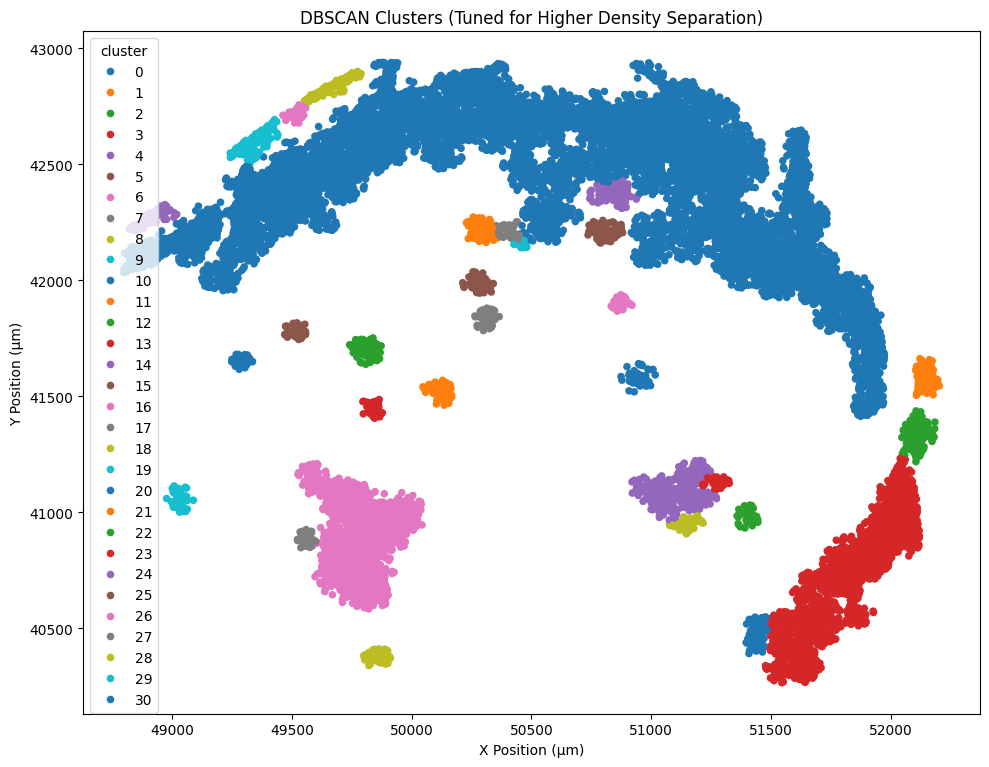

In [18]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter the DataFrame to focus on relevant biology (optional)
# df_filtered = df[(df['CD11B'] == 1) & (df['MDSC'] == 1)].copy()

# Step 2: Extract and scale coordinates
coords = df_filtered[['POSITION X', 'POSITION Y']].values
coords_scaled = StandardScaler().fit_transform(coords)

# Step 3: Apply DBSCAN with tighter settings
dbscan = DBSCAN(eps=0.05, min_samples=30)  # <-- tuned tighter
labels = dbscan.fit_predict(coords_scaled)

# Step 4: Filter out noise (label == -1)
mask = labels != -1
filtered_coords = coords[mask]
filtered_labels = labels[mask]

# Step 5: Plot
df_plot = pd.DataFrame(filtered_coords, columns=['POSITION X', 'POSITION Y'])
df_plot['cluster'] = filtered_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_plot,
    x='POSITION X', y='POSITION Y',
    hue='cluster',
    palette='tab10', s=30, linewidth=0
)
plt.title('DBSCAN Clusters (Tuned for Higher Density Separation)')
plt.xlabel('X Position (µm)')
plt.ylabel('Y Position (µm)')
# plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.show()


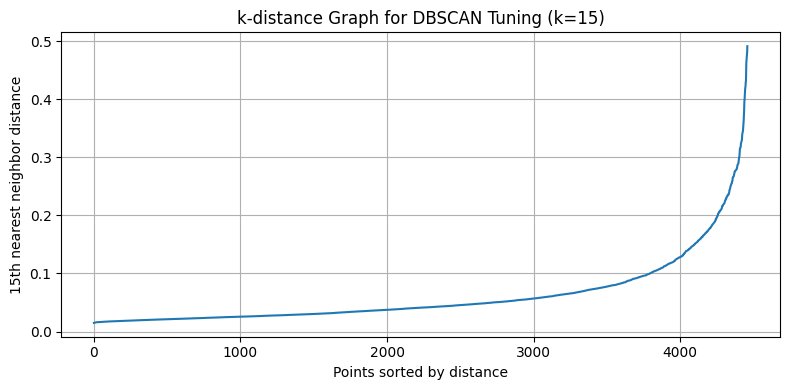

In [49]:
from sklearn.neighbors import NearestNeighbors

# Use 15 nearest neighbors since min_samples=15
neighbors = NearestNeighbors(n_neighbors=15)
neighbors_fit = neighbors.fit(coords_scaled)
distances, indices = neighbors_fit.kneighbors(coords_scaled)

# Plot sorted k-distances
k_distances = np.sort(distances[:, -1])
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title("k-distance Graph for DBSCAN Tuning (k=15)")
plt.xlabel("Points sorted by distance")
plt.ylabel("15th nearest neighbor distance")
plt.grid(True)
plt.tight_layout()
plt.show()
